In [63]:
import h5py
import numpy as np
import pandas as pd
from fastcore.all import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [94]:
DATA_PATH = Path('ladle_inf_data_multi_thinspan_smooth_high//////')
DATA = list(DATA_PATH.glob('no_slag/*.h5'))
DATA

[Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_close_n_mu-10000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-offset_separated_n_mu-1000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_separated_n_mu-1000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_close_n_mu-1000.h5'),
 Path('ladle_inf_data_multi_thinspan_smooth_high/no_slag/det-central_separated_n_mu-10000.h5')]

In [177]:
def get_new_pred(poca_xyz, poca_xyz_unc, eff, xy_sig_wgt):
    r'''
    New version of inferrence with clamping
    '''
    
    z_pos = poca_xyz[:, 2:]
    z_unc = poca_xyz_unc[:, 2:]
    
    z_unc = np.clip(z_unc, np.percentile(z_unc, 15.865), np.percentile(z_unc, 84.135))
        
    wgt = xy_sig_wgt * eff / (z_unc**2)
    wgt = np.clip(wgt, 0, np.percentile(z_unc, 84.135))
    
    mean_z = (wgt * z_pos).sum() / wgt.sum()
    return mean_z[None]

In [178]:
df = pd.DataFrame()
for path in DATA:
    with h5py.File(path, 'r') as h5:
        for grp in h5.keys():
            tmp_df = pd.DataFrame({
                'detector':path.stem.split('_n_mu')[0],
                'n_mu':int(path.stem.split('-')[-1]),
                'targ_h':h5[grp]['targ_h'][()],
                'pred_h':h5[grp]['pred_h'][()],
                'n_rec_muons':h5[grp]['muon_efficiency'][()].shape[0],
                'mean_z_unc':h5[grp]['poca_xyz_unc'][:,2].mean(),
                'mean_z':h5[grp]['poca_xyz'][:,2].mean(),
                'mean_xy_unc':h5[grp]['poca_xyz_unc'][:,:2].mean(),
                'mean_xy_sig_wgt':h5[grp]['muon_xy_sig_wgt'][()].mean(),
                'std_xy_sig_wgt':h5[grp]['muon_xy_sig_wgt'][()].std(),
                'std_wgt':h5[grp]['muon_wgt'][()].std(),
                'mean_wgt':h5[grp]['muon_wgt'][()].mean(),
                'new_pred':get_new_pred(poca_xyz=h5[grp]['poca_xyz'][()], poca_xyz_unc=h5[grp]['poca_xyz_unc'][()], eff=h5[grp]['muon_efficiency'][()], xy_sig_wgt=h5[grp]['muon_xy_sig_wgt'][()])
            })
            df = df.append(tmp_df, ignore_index=True)

# Process data 

In [179]:
df['bias'] = df.targ_h-df.pred_h
df['new_bias'] = df.targ_h-df.new_pred
df['basic_bias'] = df.targ_h-df.mean_z

In [180]:
df

,detector,n_mu,targ_h,pred_h,n_rec_muons,mean_z_unc,mean_z,mean_xy_unc,mean_xy_sig_wgt,std_xy_sig_wgt,std_wgt,mean_wgt,new_pred,bias,new_bias,basic_bias
0,det-central_close,10000,0.4,0.496187,2052,1.134189,0.659549,0.159979,0.549890,0.186908,4.576799e+04,1.174956e+04,0.685371,-0.096187,-0.285371,-0.259549
1,det-central_close,10000,0.4,0.504192,2019,1.330096,0.687285,0.191751,0.550723,0.184706,5.135880e+04,1.312834e+04,0.699910,-0.104192,-0.299910,-0.287285
2,det-central_close,10000,0.4,0.472770,1995,1.492392,0.654664,0.163603,0.550332,0.189412,6.831076e+04,1.406783e+04,0.689861,-0.072770,-0.289861,-0.254664
3,det-central_close,10000,0.4,0.528312,2003,1.738766,0.670997,0.209833,0.551093,0.188189,5.277521e+04,1.482665e+04,0.692561,-0.128312,-0.292561,-0.270997
4,det-central_close,10000,0.6,0.500866,2006,1.085430,0.617339,0.143955,0.573492,0.176462,5.642859e+04,1.577536e+04,0.634601,0.099134,-0.034601,-0.017339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,det-central_separated,10000,1.2,0.486259,1306,0.038950,0.796650,0.004003,0.645288,0.148243,6.026200e+06,3.051730e+06,0.798045,0.713741,0.401955,0.403350
214,det-central_separated,10000,1.2,0.489445,1377,0.076020,0.761337,0.007833,0.632938,0.155035,6.198842e+06,3.448522e+06,0.761337,0.710555,0.438663,0.438663
215,det-central_separated,10000,1.2,0.505610,1417,0.042827,0.784456,0.004022,0.648892,0.149662,7.502611e+06,3.461192e+06,0.784455,0.694390,0.415545,0.415545
216,det-central_separated,10000,1.2,0.468158,1418,0.044814,0.797469,0.003896,0.639778,0.151883,6.233061e+06,3.237780e+06,0.797469,0.731842,0.402531,0.402531


# Interpret data 

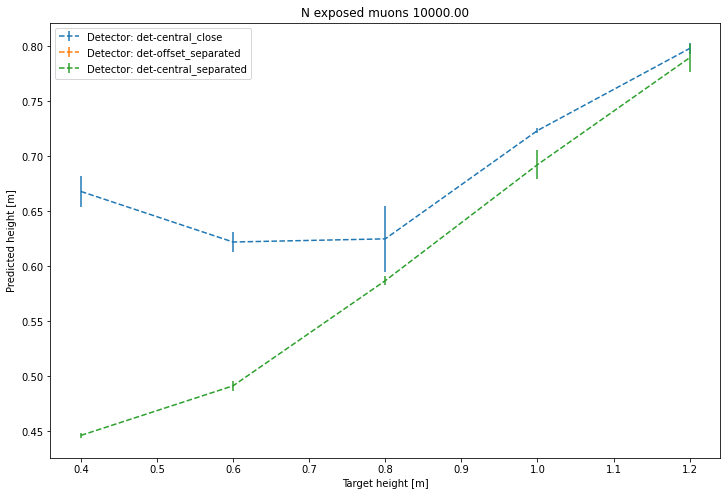

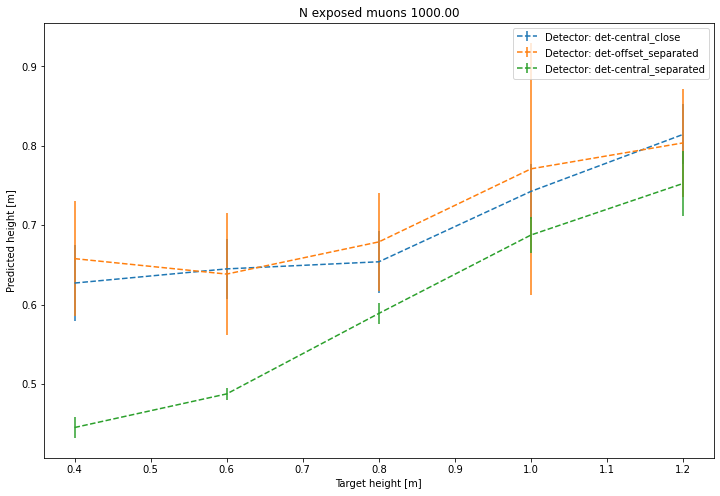

In [181]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df[(df.detector == det) & (df.n_mu == n_mu)].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['pred_h', 'new_pred', 'mean_z']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, agg.mean_z_mean, yerr=agg.mean_z_std, label=f'Detector: {det}', color=pallete[i], linestyle='--')
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Predicted height [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

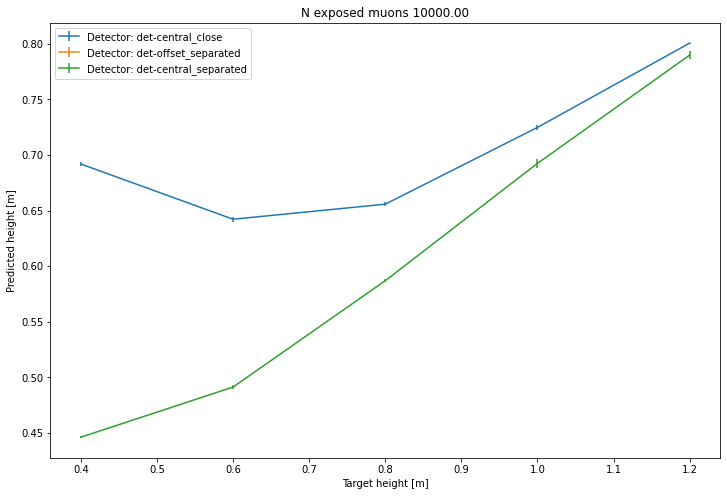

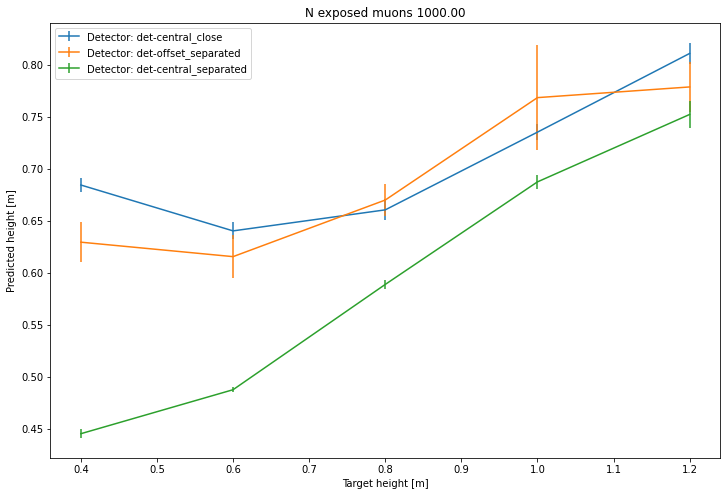

In [182]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df.loc[(df.detector == det) & (df.n_mu == n_mu), ['targ_h', 'pred_h', 'new_pred']].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['pred_h', 'new_pred']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, agg.new_pred_mean, yerr=agg.new_pred_std/np.sqrt(10), label=f'Detector: {det}', color=pallete[i])
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Predicted height [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

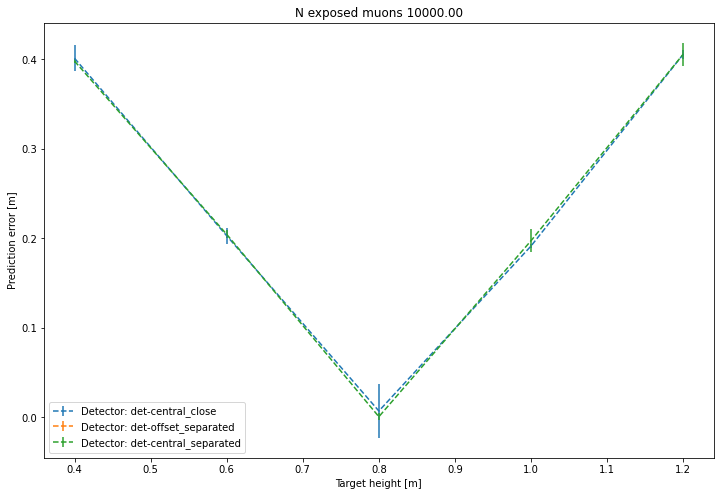

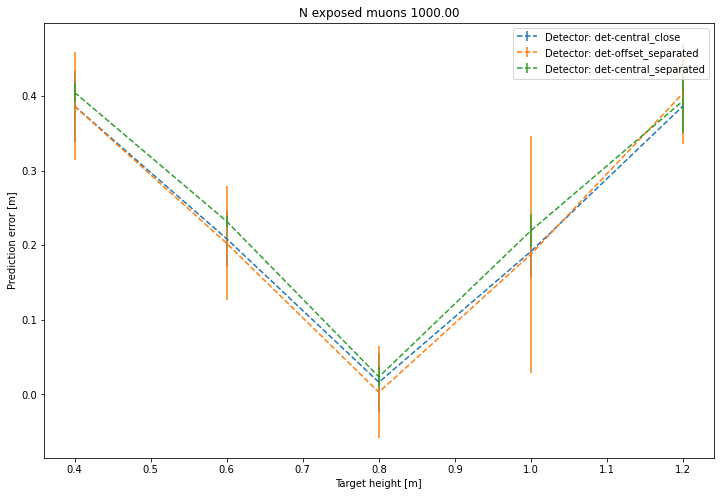

In [188]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df[(df.detector == det) & (df.n_mu == n_mu)].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['bias', 'new_bias', 'basic_bias']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, (agg.bias_mean-agg.bias_mean.mean()).abs(), yerr=agg.basic_bias_std, label=f'Detector: {det}', color=pallete[i], linestyle='--')
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Prediction error [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

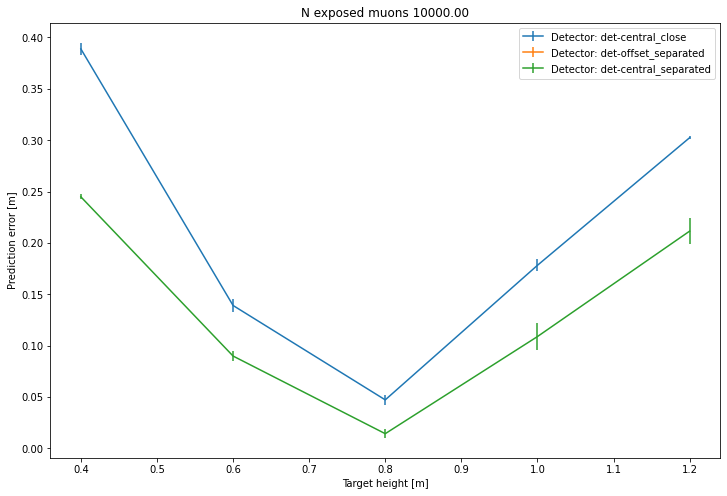

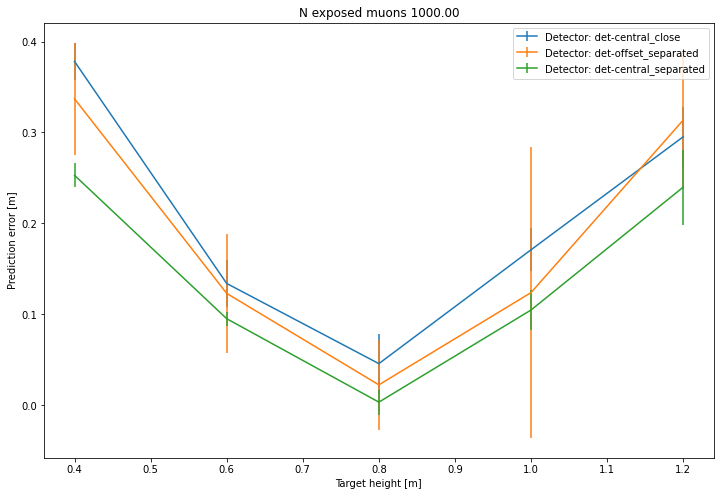

In [189]:
for n_mu in df.n_mu.unique():
    with sns.axes_style({'style':'whitegrid', 'rc':{'patch.edgecolor':'none'}}), sns.color_palette('tab10') as pallete: 
        fig = plt.figure(figsize=(12,8))
        for i, det in enumerate(df.detector.unique()):
            sdf = df.loc[(df.detector == det) & (df.n_mu == n_mu), ['targ_h', 'bias', 'new_bias']].sort_values('targ_h')
            grps = sdf.groupby('targ_h')
            agg = grps.agg({f:['mean', 'std'] for f in ['bias', 'new_bias']})
            agg.columns = ['_'.join(c).strip() for c in agg.columns.values]
            agg.reset_index(inplace=True)
            plt.errorbar(agg.targ_h, (agg.new_bias_mean-agg.new_bias_mean.mean()).abs(), yerr=agg.new_bias_std, label=f'Detector: {det}', color=pallete[i])
            
        plt.xlabel('Target height [m]')
        plt.ylabel('Prediction error [m]')
        plt.legend()
        plt.title(f'N exposed muons {n_mu:.2f}')
        plt.show()

# Correction